In [1]:

import re, numpy as np, string, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from nltk.stem.wordnet import WordNetLemmatizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette


import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [101]:
df = pd.read_csv('CSV_Final_negative_sf.csv')

## NLTK Stop words

In [3]:

stop_words = stopwords.words('english')

#stop_words.extend([])

In [4]:
type(stop_words)

list

## Vectorizing & Document Matrix

In [5]:
vectorizer = CountVectorizer(stop_words='english')

docs = vectorizer.fit_transform(df.comments)

features = vectorizer.get_feature_names()


In [6]:

tf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)

docs = tf.fit_transform(df['comments'])

features = tf.get_feature_names()



"\ntf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)\n\ndocs = tf.fit_transform(df['comments'])\n\nfeatures = tf.get_feature_names()\n\n"

## Read samples of reviews

In [7]:
for sample in df['spacy_doc'].sample(5).values:
    print(sample)
    print()

The best part about staying here is that the host is very attentive. They were quick to respond to my messages and questions. The location is fantastic as well; it's quick and easy to walk to many restaurants or local sights. Wifi worked well throughout my stay. The downside is the windows don't have much of a view. I kept the blinds shut throughout the stay because one window looks out to a neighbor's window and the other looks out to a common area shared by other neighbors. Additionally the kitchen has the basics but not much more (for example, 1 baking sheet, no chopping knives,  no can opener, a large fruit bowl but no cereal bowls).

We had good communication through emails.  Unfortunately we never got to meet our hosts in person, as they were away.

Convenient place with comparatively low price

Everything that you can expect from a hotel

Cheap place to crash for a night. No frills, exactly as advertised. Comfy bed!



In [8]:
for sample in df['comments'].sample(5).values:
    print(sample)
    print()

.

The host canceled this reservation 118 days before arrival. This is an automated posting.

THERE WAS ANOTHER COUPLE IN THE ROOM WHEN I ARRIVED!! <br/><br/>So, let me start out by saying that I communicated with this "super host" explicitly. I even went further to confirm that he understood my reservation and timing, as I was traveling from the east coast and wanted him to be well aware that my flight would be getting in very late. To which he then confirmed that it would be "ok" and went ahead and reserved my stay. So, it was not only surprising to find another couple in the room once I arrived but HIGHLY frustrating seeing as it was nearly 1:30 in the morning!  (oh and he requested that I let him know when I was omw once I got off the plane, which I did. like I stated I knew it would be a late arrival) Not to mention that the code he gave me worked. So imagine using your "own" code but then walking in and someone is sitting there in their boxers!! He was startled! I was alarmed! IT

## Most Used Words

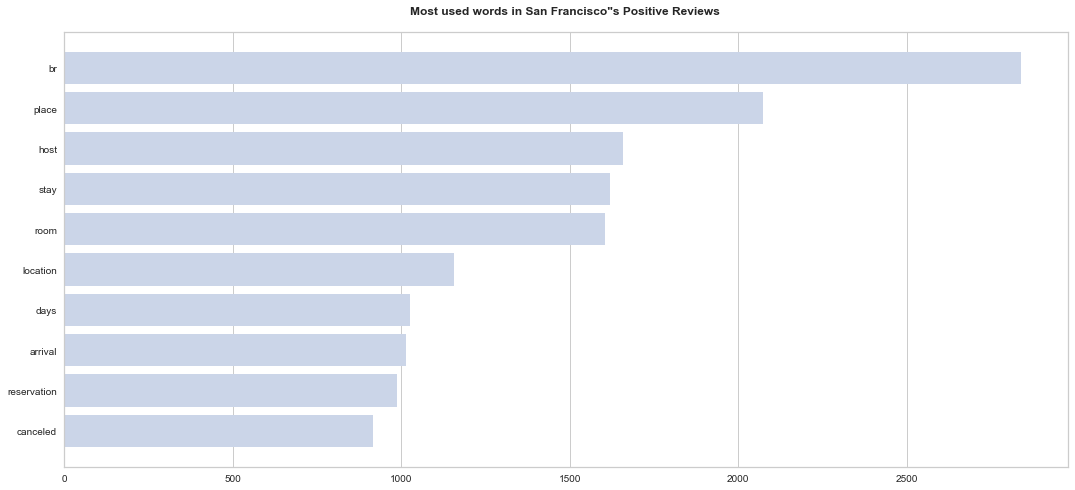

In [9]:
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('Most used words in San Francisco"s Positive Reviews \n', fontweight='bold')

##yellowbrick
vis = FreqDistVisualizer(features=features, n = 10)
vis.fit(docs)
vis.poof;

## Creating World Cloud words

In [99]:
def wordcloud_words(wordcloud):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(' San Francisco Negative Reviews\n', fontsize=18, fontweight='bold')
    plt.savefig('SFNegativeReviews')
    plt.show()

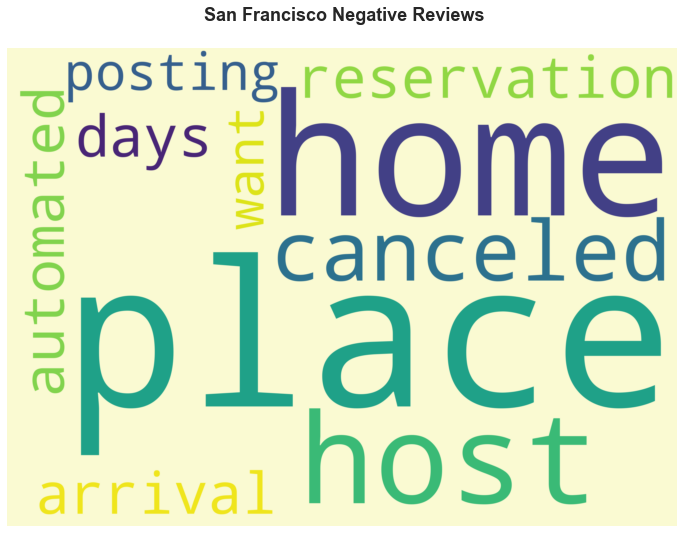

In [100]:
posWords = WordCloud(max_font_size=None, max_words = 10, background_color="lightgoldenrodyellow", 
                      width=3500, height=2500,
                      stopwords=stopwords.words('english')).generate(str(df.comments.values))

wordcloud_words(posWords)

## Simple Additional Cleaning

In [12]:
def clean(sents):
    for word in sents:
        word = re.sub('\s+', ' ', word)  
        word = re.sub("\'", "", word)  
        word = gensim.utils.simple_preprocess(str(word), deacc=True) 
        yield(word)  


# Apply cleaning

In [13]:
all_data = df.comments.values.tolist()
clean_sent = list(clean(all_data))
print(clean_sent[:1])

[['the', 'host', 'canceled', 'this', 'reservation', 'days', 'before', 'arrival', 'this', 'is', 'an', 'automated', 'posting']]


In [14]:
print(clean_sent[:5])

[['the', 'host', 'canceled', 'this', 'reservation', 'days', 'before', 'arrival', 'this', 'is', 'an', 'automated', 'posting'], [], ['if', 'you', 'want', 'to', 'fell', 'the', 'concept', 'being', 'home', 'away', 'of', 'home', 'stay', 'at', 'holly', 'place', 'really', 'wonder', 'full', 'place', 'and', 'she', 'is', 'an', 'excelent', 'hostess'], ['on', 'very', 'quiet', 'residential', 'street', 'but', 'close', 'to', 'transportation', 'holly', 'responded', 'to', 'texts', 'immediately', 'would', 'return'], []]


## Bigram & Trigram

In [15]:

bi_gram = gensim.models.Phrases(clean_sent, min_count=5, threshold=100) 

tri_gram = gensim.models.Phrases(bi_gram[clean_sent], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bi_gram)

trigram_mod = gensim.models.phrases.Phraser(tri_gram)

## Clean, Remove & Lemma

In [16]:

def cleaning(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    nlp = spacy.load("en_core_web_sm")
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])     
    
    clean_text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    
    return clean_text


## Apply final cleaning on prev cleaned list

In [17]:
doc_clean = cleaning(clean_sent)
doc_clean[:5]

[['cancel', 'reservation', 'day', 'arrival', 'automated_poste'],
 [],
 ['fall',
  'concept',
  'home',
  'away',
  'home',
  'stay',
  'holly',
  'place',
  'really',
  'wonder',
  'full',
  'place',
  'excelent',
  'hostess'],
 ['quiet',
  'residential',
  'street',
  'close',
  'transportation',
  'holly',
  'respond',
  'text',
  'immediately',
  'return'],
 []]

## Create Dictionary & Corpus

In [18]:
doc_dict = corpora.Dictionary(doc_clean)

corpus = [doc_dict.doc2bow(text) for text in doc_clean]


## Build The LDA model

In [19]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=8, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.048*"experience" + 0.041*"kitchen" + 0.039*"stay" + 0.031*"open" + '
  '0.027*"time" + 0.027*"bedroom" + 0.025*"next" + 0.025*"overall" + '
  '0.024*"break" + 0.021*"problem"'),
 (1,
  '0.108*"room" + 0.042*"night" + 0.033*"bed" + 0.028*"check" + 0.025*"hotel" '
  '+ 0.021*"apartment" + 0.020*"people" + 0.020*"sleep" + 0.017*"guest" + '
  '0.014*"price"'),
 (2,
  '0.054*"br" + 0.037*"clean" + 0.031*"great" + 0.030*"bathroom" + '
  '0.025*"small" + 0.023*"find" + 0.023*"look" + 0.022*"tell" + 0.021*"dirty" '
  '+ 0.020*"issue"'),
 (3,
  '0.142*"stay" + 0.134*"place" + 0.036*"leave" + 0.036*"area" + 0.034*"hour" '
  '+ 0.031*"really" + 0.017*"due" + 0.016*"towel" + 0.016*"much" + '
  '0.015*"well"'),
 (4,
  '0.163*"day" + 0.106*"airbnb" + 0.097*"feel" + 0.084*"work" + '
  '0.054*"reservation" + 0.051*"first" + 0.047*"cancel" + 0.042*"restaurant" + '
  '0.032*"hard" + 0.032*"arrival"'),
 (5,
  '0.142*"parking" + 0.065*"street" + 0.051*"car" + 0.040*"close" + '
  '0.037*"park" + 

## List of words by topic

In [20]:
topics = lda_model.show_topics(formatted=False)

In [21]:
type(topics)

list

In [22]:
topics

[(0,
  [('experience', 0.047560085),
   ('kitchen', 0.04117137),
   ('stay', 0.039197687),
   ('open', 0.03139817),
   ('time', 0.027498838),
   ('bedroom', 0.026962988),
   ('next', 0.02488111),
   ('overall', 0.024668312),
   ('break', 0.023784583),
   ('problem', 0.021178547)]),
 (1,
  [('room', 0.10817643),
   ('night', 0.042192828),
   ('bed', 0.032622304),
   ('check', 0.027508473),
   ('hotel', 0.025346588),
   ('apartment', 0.021015635),
   ('people', 0.020448497),
   ('sleep', 0.020166928),
   ('guest', 0.017036546),
   ('price', 0.014304874)]),
 (2,
  [('br', 0.053877823),
   ('clean', 0.037392944),
   ('great', 0.030976241),
   ('bathroom', 0.030127821),
   ('small', 0.024687292),
   ('find', 0.023457555),
   ('look', 0.022724362),
   ('tell', 0.02181591),
   ('dirty', 0.021333762),
   ('issue', 0.019983666)]),
 (3,
  [('stay', 0.14175273),
   ('place', 0.13352403),
   ('leave', 0.035978258),
   ('area', 0.03561081),
   ('hour', 0.033887036),
   ('really', 0.030843165),
   (

## Visualize the words By Topic

In [23]:
topics = lda_model.show_topics(formatted=False)

In [24]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [25]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [26]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
40,day,4,0.163096,1486
50,parking,5,0.141948,653
30,stay,3,0.141753,2061
60,location,6,0.133579,1165
31,place,3,0.133524,2056
10,room,1,0.108176,1800
41,airbnb,4,0.105594,384
42,feel,4,0.097420,399
43,work,4,0.084267,351
51,street,5,0.065255,456


## Word Count as Weights by Topic Visualization

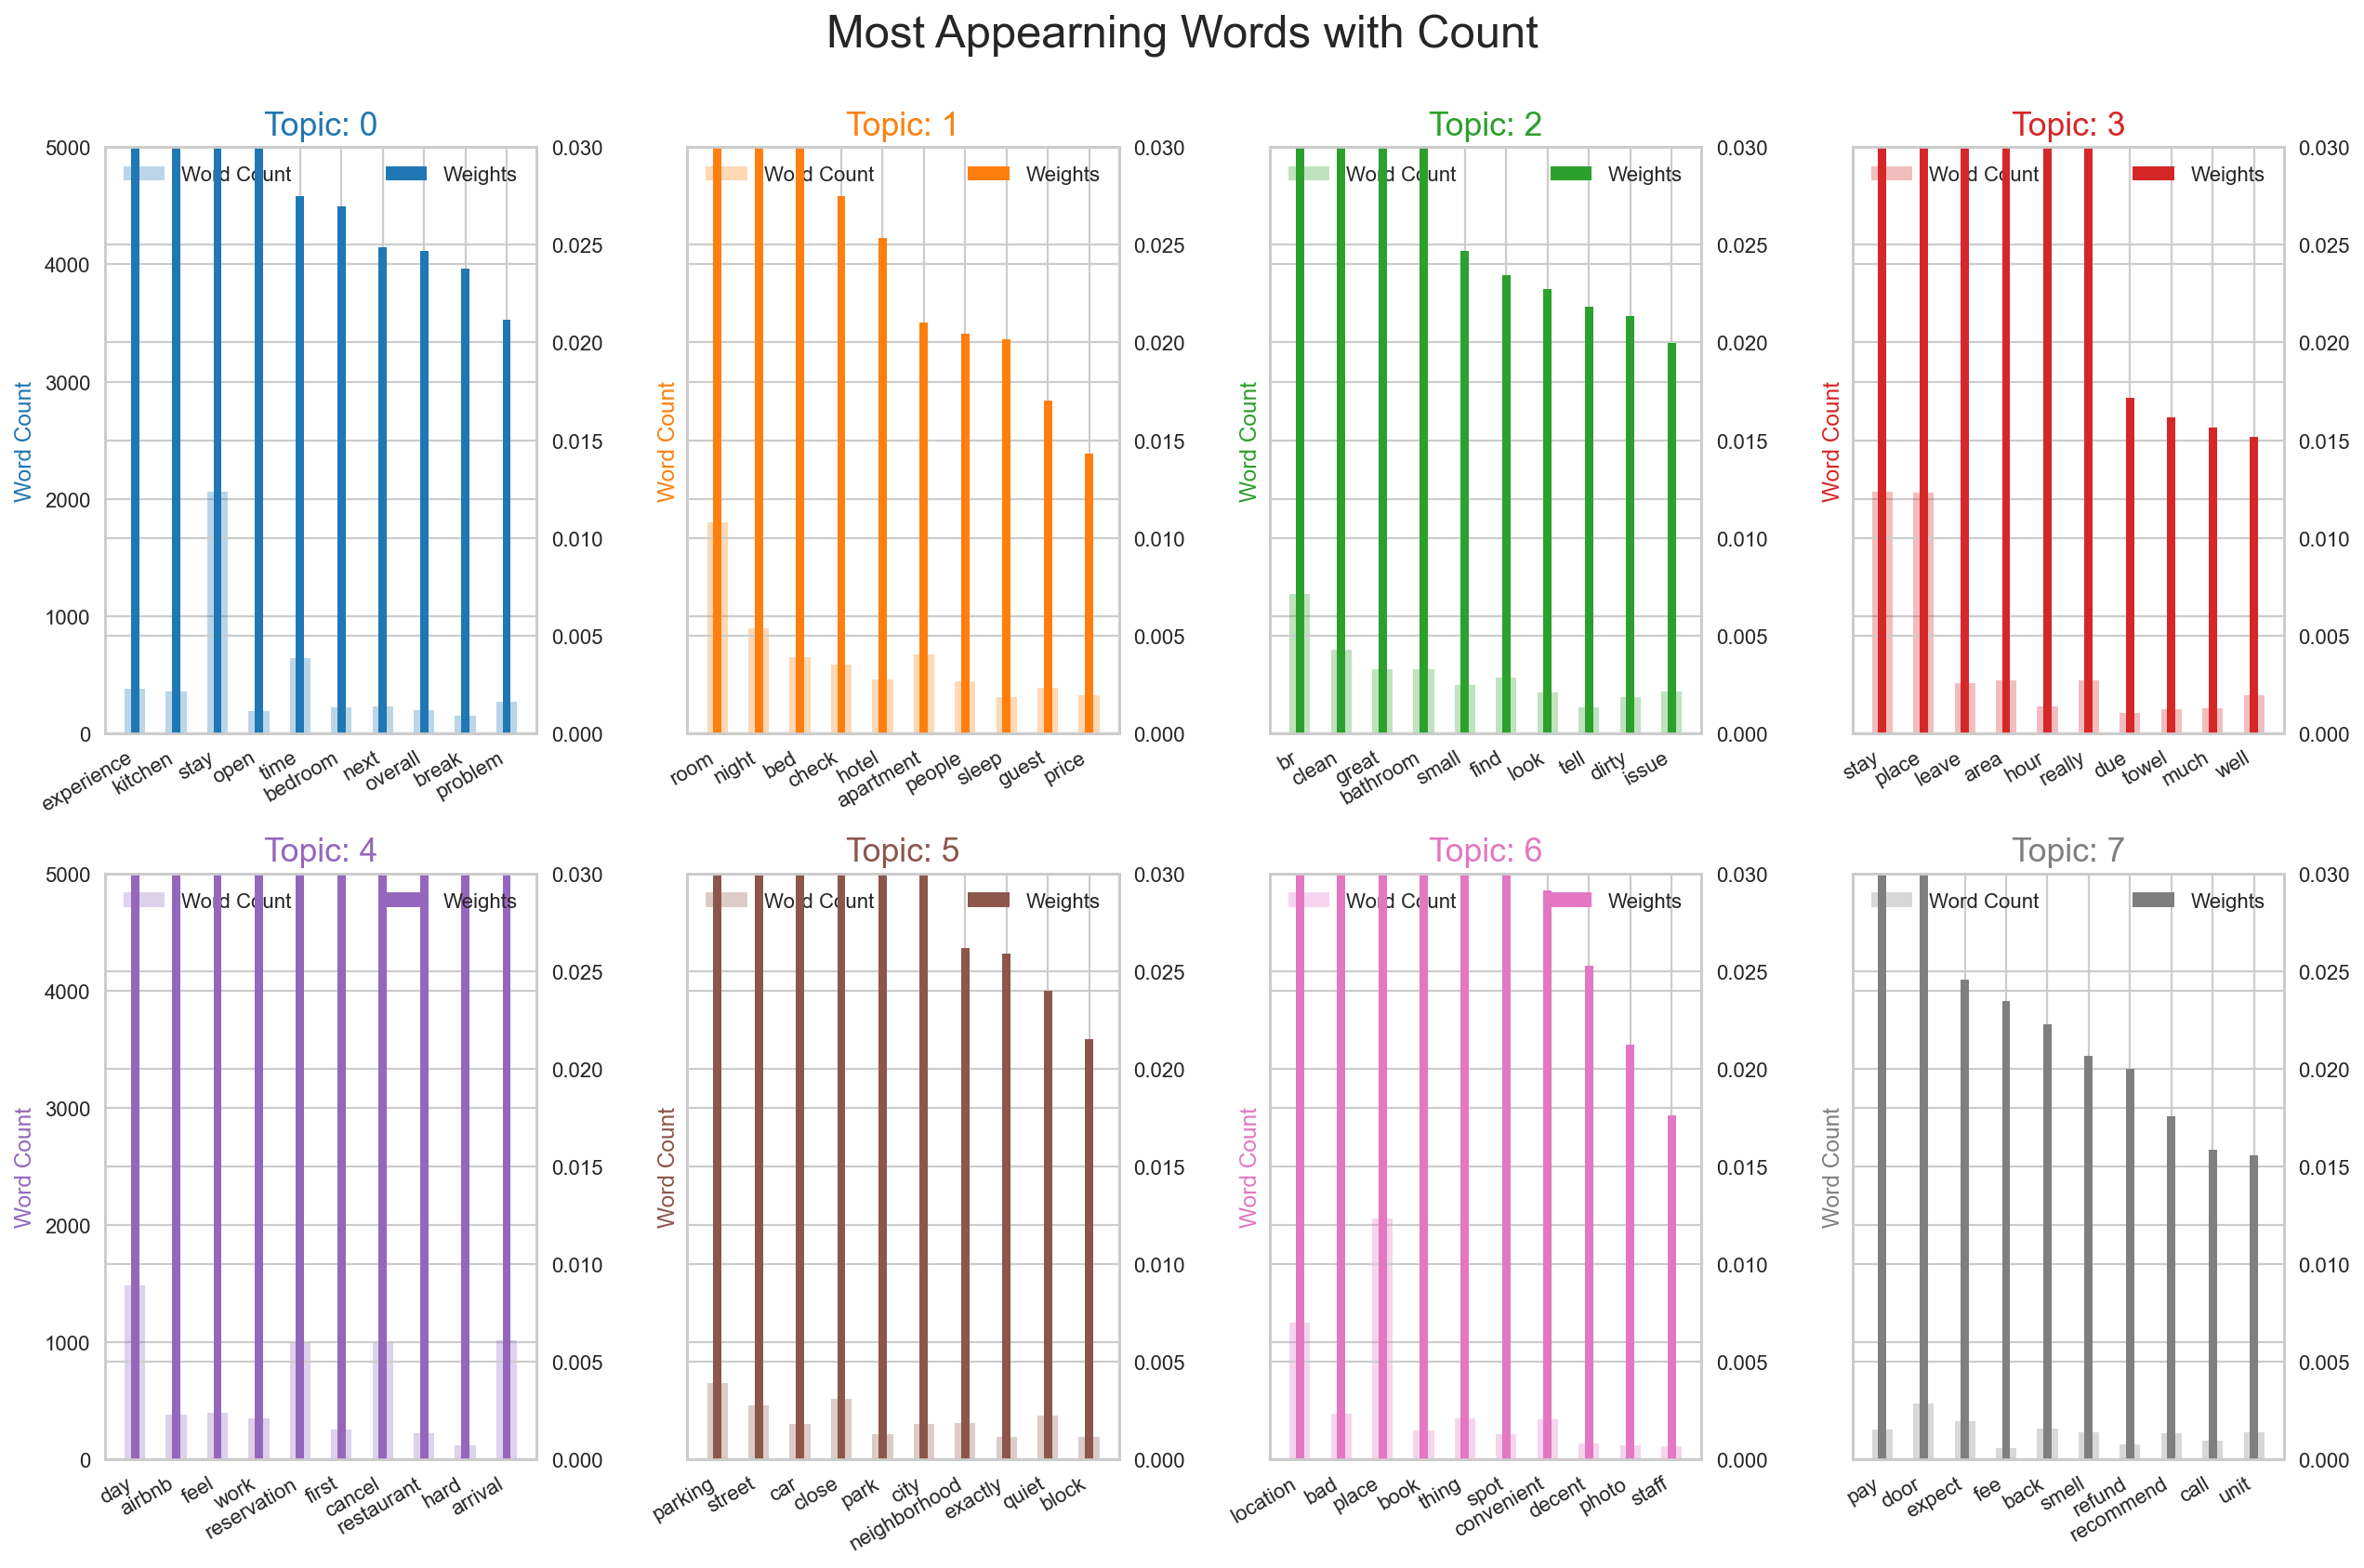

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [28]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


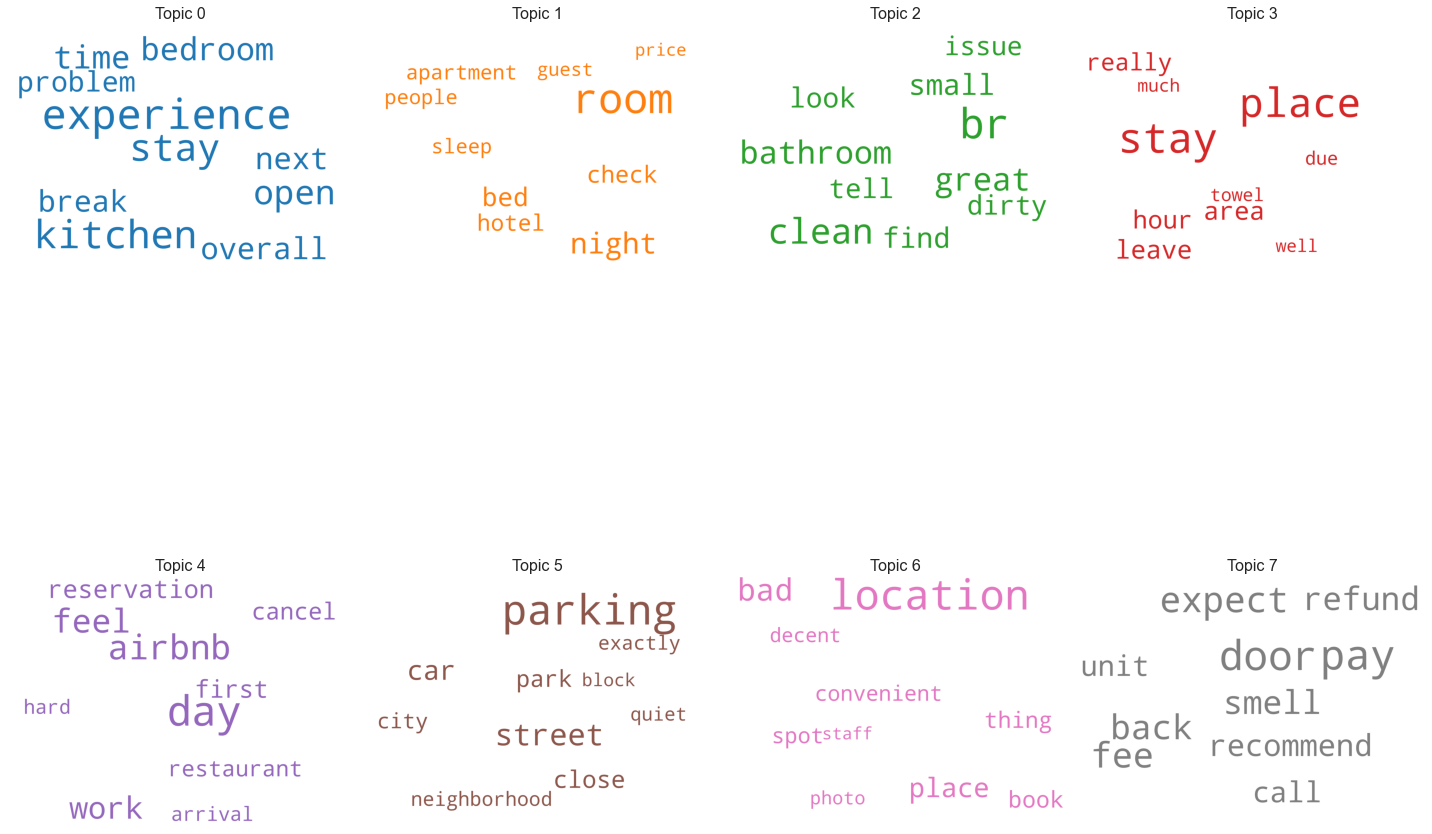

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 3 topics

In [30]:

nmf = NMF(n_components=3)

nmf.fit(docs)

NMF(n_components=3)

In [31]:
topic_matrix = nmf.transform(docs)

In [32]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,comments
0,0.000000,0.000000,0.306998,The host canceled this reservation 12 days bef...
1,0.000000,0.000000,0.000000,.
2,0.000000,0.120643,0.000000,"If you want to fell the concept "" Being home ..."
3,0.000223,0.018834,0.000000,"On a very quiet residential street, but close ..."
4,0.000862,0.004818,0.001514,10/10


In [33]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2
00,0.007856,0.069683,0.000452
000,0.001563,0.006426,0.001006
0000,0.003309,0.000000,0.000000
00am,0.003936,0.000024,0.000000
00pm,0.001813,0.016648,0.000000


## Read Samples from Topic 0 

In [34]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

## Read Samples from Topic 1 


In [35]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Not the ‘peace hostel’ experience I was expecting. Despite the very impersonal check in system, with codes on doors which can be guessed with an IQ of 70, there were actually two members of staff on site for my 5 night stay. Both of whom were rude, one in particular who was badmouthing me and my friends in front of and behind our backs, after we asked for some assistance with their room. My room was aptly named the sunshine room as the curtains are so thin the sun comes through in the morning interrupting my sleep, but other than that the room didn’t not fit the description. It was dirty, my bed wasn’t properly made, the towels were stained and the rug on the floor was so filthy I didn’t take my socks off once. This is a hostel, but a very expensive hostel, and Despite someone coming in daily to ‘make’ your bed by smoothing the sheet and delivering more ‘clean’ towels, there were no other perks to warrant the cost of this place per night. It cost me £125 per night plus a cleaning fee(!

## Read Samples from Topic 2


In [36]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.



# Top 10 Words from Each Topic

In [37]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [38]:
display_topics(nmf, features, 10)


Topic  0
br, airbnb, door, kitchen, apartment, house, did, unit, host, left

Topic  1
room, place, stay, night, location, clean, did, just, apartment, host

Topic  2
host, arrival, reservation, canceled, posting, automated, days, day, 11, 17


In [39]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2
br,12.432345,0.000000,0.000000
airbnb,0.472139,1.139916,0.073874
door,0.425726,1.282965,0.000000
kitchen,0.369525,0.783163,0.000000
apartment,0.355005,1.335026,0.027638
house,0.347407,1.312116,0.014092
did,0.345667,1.370607,0.054554
unit,0.334537,0.429597,0.038352
host,0.319715,1.319251,3.643991
left,0.319572,0.580584,0.028919


In [40]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2
room,0.221660,4.333374,0.000000
place,0.000000,4.108207,0.000000
stay,0.136157,3.302218,0.009315
night,0.289490,2.095568,0.000000
location,0.138927,1.572421,0.000000
clean,0.149873,1.373578,0.000000
did,0.345667,1.370607,0.054554
just,0.041426,1.340739,0.000000
apartment,0.355005,1.335026,0.027638
host,0.319715,1.319251,3.643991


In [41]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2
host,0.319715,1.319251,3.643991
arrival,0.004943,0.000000,3.249911
reservation,0.000000,0.000000,3.246213
canceled,0.000000,0.000000,3.168618
posting,0.000000,0.000000,3.162024
automated,0.000000,0.000000,3.160363
days,0.093828,0.042362,3.135837
day,0.252370,1.111337,0.152274
11,0.004950,0.050386,0.089131
17,0.000000,0.006853,0.081896


In [42]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [43]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

In [44]:
top_words(word_topic_matrix_df, 'topic_0', 10)

br           12.432345
airbnb        0.472139
door          0.425726
kitchen       0.369525
apartment     0.355005
house         0.347407
did           0.345667
unit          0.334537
host          0.319715
left          0.319572
Name: topic_0, dtype: float64

In [45]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Not the ‘peace hostel’ experience I was expecting. Despite the very impersonal check in system, with codes on doors which can be guessed with an IQ of 70, there were actually two members of staff on site for my 5 night stay. Both of whom were rude, one in particular who was badmouthing me and my friends in front of and behind our backs, after we asked for some assistance with their room. My room was aptly named the sunshine room as the curtains are so thin the sun comes through in the morning interrupting my sleep, but other than that the room didn’t not fit the description. It was dirty, my bed wasn’t properly made, the towels were stained and the rug on the floor was so filthy I didn’t take my socks off once. This is a hostel, but a very expensive hostel, and Despite someone coming in daily to ‘make’ your bed by smoothing the sheet and delivering more ‘clean’ towels, there were no other perks to warrant the cost of this place per night. It cost me £125 per night plus a cleaning fee(!

In [46]:
top_words(word_topic_matrix_df, 'topic_1', 10)

room         4.333374
place        4.108207
stay         3.302218
night        2.095568
location     1.572421
clean        1.373578
did          1.370607
just         1.340739
apartment    1.335026
host         1.319251
Name: topic_1, dtype: float64

In [47]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.



In [48]:
top_words(word_topic_matrix_df, 'topic_2', 10)

host           3.643991
arrival        3.249911
reservation    3.246213
canceled       3.168618
posting        3.162024
automated      3.160363
days           3.135837
day            0.152274
11             0.089131
17             0.081896
Name: topic_2, dtype: float64

In [49]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [50]:
tl_dict = t1.to_dict()

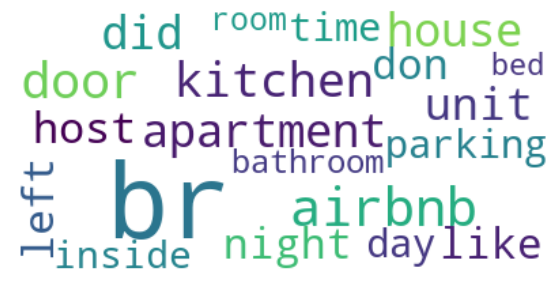

In [51]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


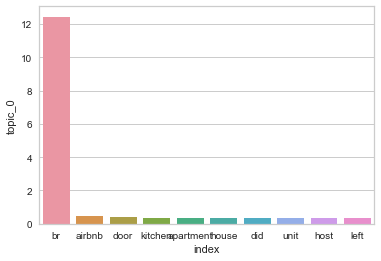

In [52]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [53]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

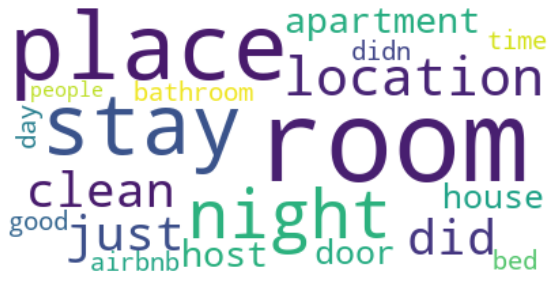

In [54]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


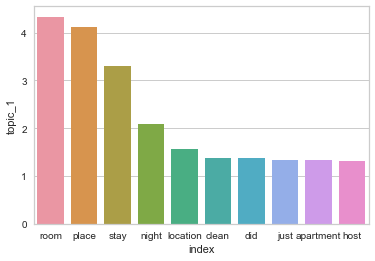

In [55]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

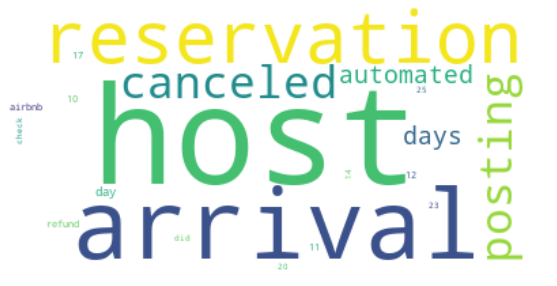

In [56]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

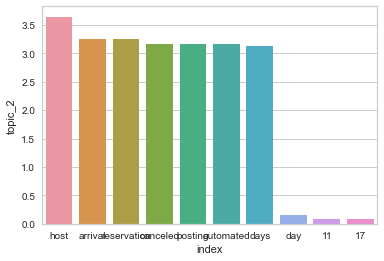

In [57]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);

## Build The LDA model With 5 Topics

In [58]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=5, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.069*"room" + 0.027*"night" + 0.021*"bed" + 0.017*"great" + 0.016*"hotel" '
  '+ 0.014*"small" + 0.014*"pay" + 0.013*"door" + 0.013*"people" + '
  '0.013*"sleep"'),
 (1,
  '0.052*"location" + 0.048*"parking" + 0.032*"place" + 0.027*"check" + '
  '0.024*"bad" + 0.022*"street" + 0.020*"apartment" + 0.017*"guest" + '
  '0.016*"walk" + 0.014*"find"'),
 (2,
  '0.057*"br" + 0.032*"bathroom" + 0.028*"time" + 0.024*"look" + 0.022*"dirty" '
  '+ 0.020*"never" + 0.018*"give" + 0.017*"ask" + 0.015*"open" + '
  '0.014*"picture"'),
 (3,
  '0.100*"stay" + 0.062*"place" + 0.021*"leave" + 0.021*"area" + 0.020*"feel" '
  '+ 0.020*"hour" + 0.019*"car" + 0.018*"really" + 0.015*"back" + '
  '0.015*"book"'),
 (4,
  '0.129*"day" + 0.083*"airbnb" + 0.067*"work" + 0.043*"reservation" + '
  '0.042*"decent" + 0.041*"first" + 0.037*"cancel" + 0.031*"show" + '
  '0.025*"hard" + 0.025*"arrival"')]


## List of words by topic

In [59]:
topics = lda_model.show_topics(formatted=False)

In [60]:
type(topics)

list

In [61]:
topics

[(0,
  [('room', 0.06910901),
   ('night', 0.026955811),
   ('bed', 0.020841615),
   ('great', 0.017222371),
   ('hotel', 0.016193926),
   ('small', 0.013726408),
   ('pay', 0.013653141),
   ('door', 0.013403309),
   ('people', 0.0130646685),
   ('sleep', 0.0128846755)]),
 (1,
  [('location', 0.05174324),
   ('parking', 0.04784239),
   ('place', 0.03231979),
   ('check', 0.026792413),
   ('bad', 0.024353717),
   ('street', 0.021994932),
   ('apartment', 0.020469379),
   ('guest', 0.016593358),
   ('walk', 0.015525461),
   ('find', 0.014356508)]),
 (2,
  [('br', 0.056598924),
   ('bathroom', 0.031650323),
   ('time', 0.027766539),
   ('look', 0.02387319),
   ('dirty', 0.022412542),
   ('never', 0.019576821),
   ('give', 0.017568108),
   ('ask', 0.016511811),
   ('open', 0.015094558),
   ('picture', 0.014424558)]),
 (3,
  [('stay', 0.09955362),
   ('place', 0.062378537),
   ('leave', 0.020965371),
   ('area', 0.020751292),
   ('feel', 0.020017272),
   ('hour', 0.01974657),
   ('car', 0.0

## Visualize the words By Topic

In [62]:
topics = lda_model.show_topics(formatted=False)

In [63]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [64]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [65]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
40,day,4,0.128854,1486
30,stay,3,0.099554,2061
41,airbnb,4,0.083426,384
0,room,0,0.069109,1800
42,work,4,0.066579,351
31,place,3,0.062379,2056
20,br,2,0.056599,1185
10,location,1,0.051743,1165
11,parking,1,0.047842,653
43,reservation,4,0.042921,991


## Word Count as Weights by Topic Visualization

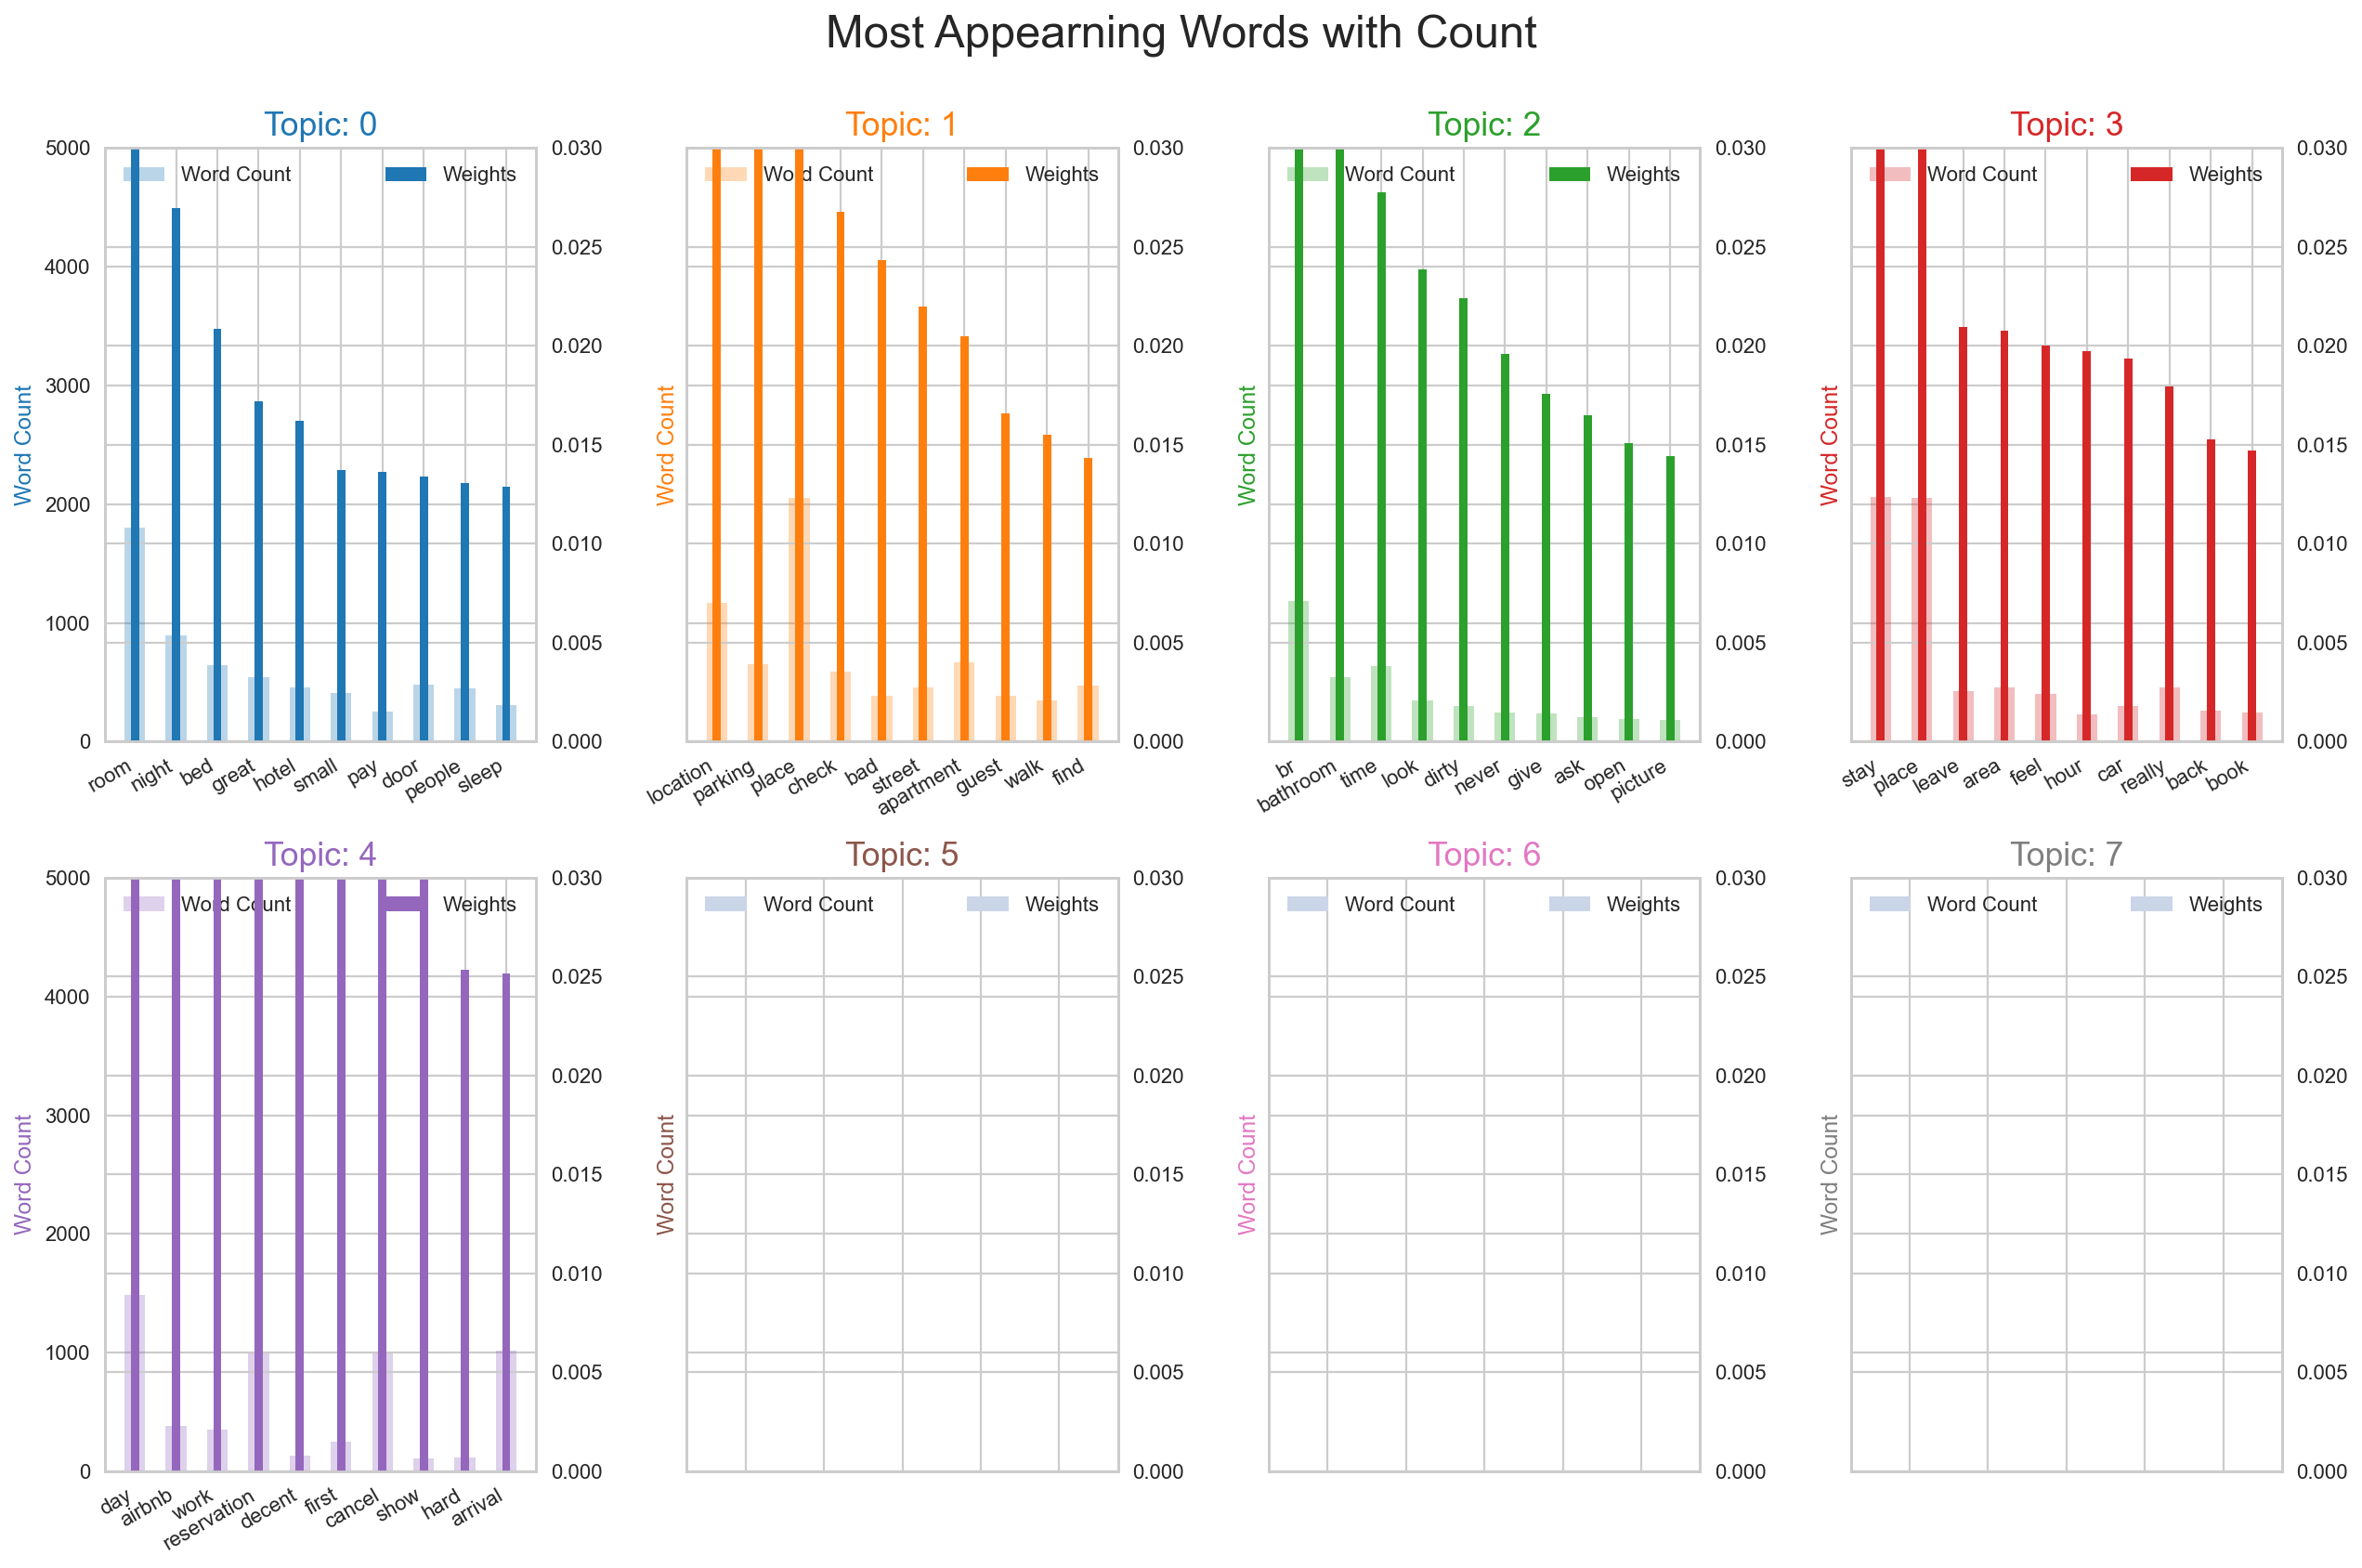

In [66]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [67]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


IndexError: list index out of range

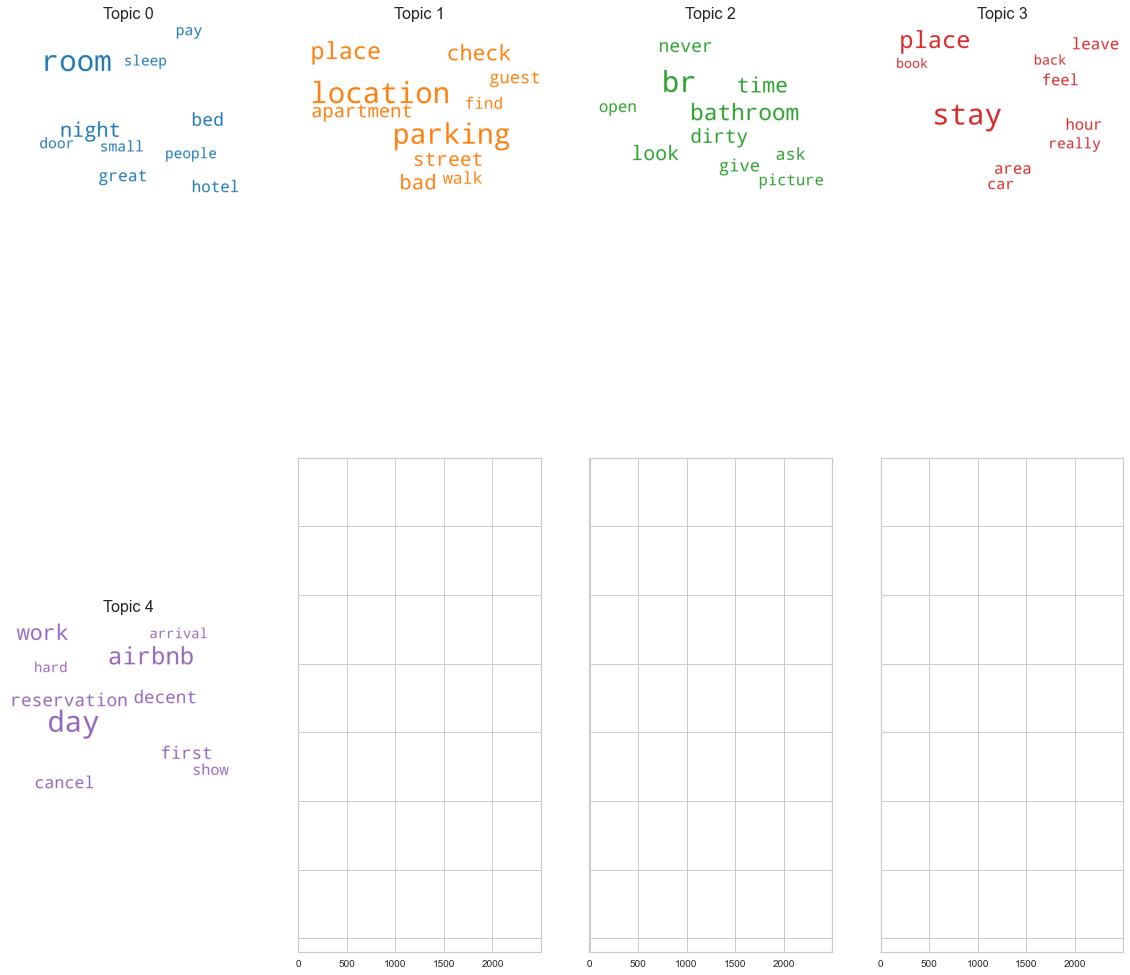

In [68]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 5 topics

In [69]:

nmf5 = NMF(n_components=5)

nmf5.fit(docs)

NMF(n_components=5)

In [70]:
topic_matrix = nmf5.transform(docs)

In [71]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,comments
0,0.00000,0.000000,0.308842,0.000000,0.000000,The host canceled this reservation 12 days bef...
1,0.00000,0.000000,0.000000,0.000000,0.000000,.
2,0.00000,0.015341,0.000000,0.000000,0.261818,"If you want to fell the concept "" Being home ..."
3,0.00019,0.012973,0.000000,0.003743,0.015372,"On a very quiet residential street, but close ..."
4,0.00060,0.006255,0.000984,0.000000,0.000776,10/10


In [72]:
word_topic_matrix_df = pd.DataFrame(nmf5.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4
00,0.002501,0.083296,0.000000,0.013447,0.018113
000,0.001353,0.001670,0.001203,0.005692,0.002436
0000,0.003228,0.000000,0.000000,0.000000,0.001262
00am,0.003749,0.001327,0.000000,0.000000,0.000000
00pm,0.000764,0.020207,0.000000,0.000000,0.007365


## Read Samples from Topic 0 

In [73]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

## Read Samples from Topic 1 


In [74]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

## Read Samples from Topic 2


In [75]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.



# Top 10 Words from Each Topic

In [76]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [77]:
display_topics(nmf, features, 10)


Topic  0
br, airbnb, door, kitchen, apartment, house, did, unit, host, left

Topic  1
room, place, stay, night, location, clean, did, just, apartment, host

Topic  2
host, arrival, reservation, canceled, posting, automated, days, day, 11, 17


In [78]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
br,12.792409,0.000000,0.000000,0.000000,0.000000
airbnb,0.344952,1.946802,0.018176,0.057338,0.000000
kitchen,0.315628,0.918623,0.000000,0.261555,0.076389
don,0.270503,0.497909,0.000000,0.102574,0.368723
door,0.269207,1.983490,0.000000,0.289417,0.000000
left,0.253957,0.965864,0.001753,0.065592,0.000000
unit,0.253221,0.915248,0.001790,0.000000,0.000000
like,0.225711,0.951198,0.000000,0.503631,0.225123
mattress,0.216348,0.000000,0.000000,0.079318,0.071783
parking,0.199762,1.112452,0.000000,0.094830,0.515567


In [79]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
stay,0.000000,4.336719,0.000000,0.000000,1.145599
apartment,0.158508,2.524558,0.000000,0.000000,0.000000
host,0.158958,2.444251,3.526042,0.000000,0.000000
did,0.194147,2.229321,0.000000,0.147652,0.000000
house,0.197932,2.147449,0.000000,0.139962,0.000000
night,0.152694,2.059651,0.000000,0.938634,0.283901
door,0.269207,1.983490,0.000000,0.289417,0.000000
airbnb,0.344952,1.946802,0.018176,0.057338,0.000000
time,0.147078,1.692029,0.000000,0.159141,0.138178
day,0.159353,1.623758,0.118876,0.117415,0.096108


In [80]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
host,0.158958,2.444251,3.526042,0.000000,0.000000
reservation,0.000000,0.000000,3.249461,0.000000,0.000000
arrival,0.017237,0.000000,3.248309,0.016815,0.000000
canceled,0.000000,0.000000,3.176294,0.000000,0.000000
posting,0.000000,0.000000,3.170329,0.000000,0.000000
automated,0.000000,0.000000,3.168300,0.000000,0.000000
days,0.100234,0.071041,3.133183,0.017717,0.025136
day,0.159353,1.623758,0.118876,0.117415,0.096108
11,0.000000,0.083981,0.086123,0.000000,0.003151
17,0.000000,0.002152,0.082375,0.000000,0.011395


In [81]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [82]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

In [83]:
top_words(word_topic_matrix_df, 'topic_0', 10)

br          12.792409
airbnb       0.344952
kitchen      0.315628
don          0.270503
door         0.269207
left         0.253957
unit         0.253221
like         0.225711
mattress     0.216348
parking      0.199762
Name: topic_0, dtype: float64

In [84]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

In [85]:
top_words(word_topic_matrix_df, 'topic_1', 10)

stay         4.336719
apartment    2.524558
host         2.444251
did          2.229321
house        2.147449
night        2.059651
door         1.983490
airbnb       1.946802
time         1.692029
day          1.623758
Name: topic_1, dtype: float64

In [86]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.



In [87]:
top_words(word_topic_matrix_df, 'topic_2', 10)

host           3.526042
reservation    3.249461
arrival        3.248309
canceled       3.176294
posting        3.170329
automated      3.168300
days           3.133183
day            0.118876
11             0.086123
17             0.082375
Name: topic_2, dtype: float64

In [88]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [89]:
tl_dict = t1.to_dict()

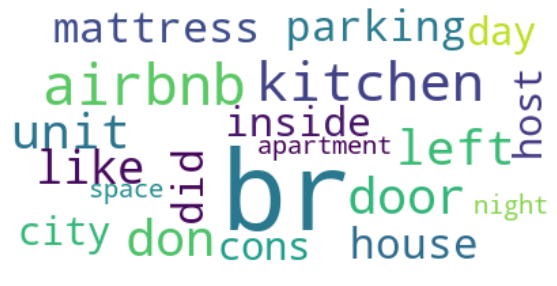

In [90]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


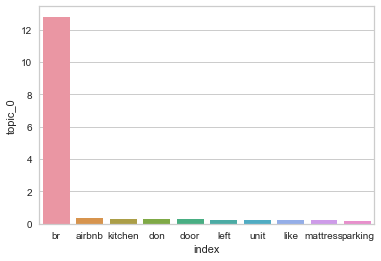

In [91]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [92]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

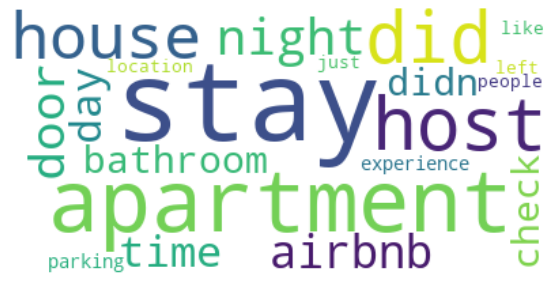

In [93]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


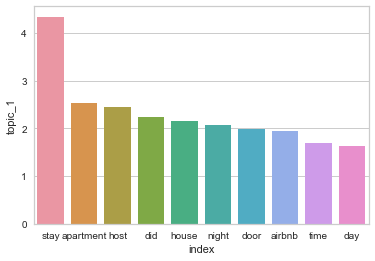

In [94]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

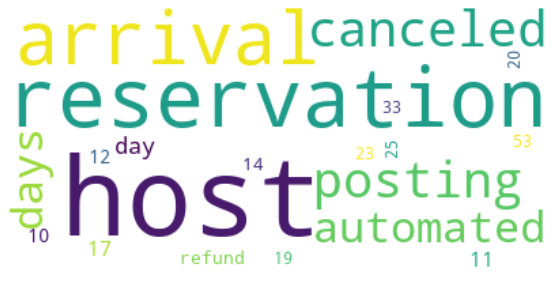

In [95]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

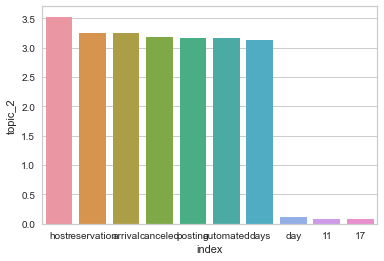

In [96]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);